In [2]:
import sys,os,time
import pandas as pd
import numpy as np
from numba import jit
import numba as nb
from tqdm.notebook import tqdm

from scipy.integrate import quad

#--matplotlib
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('text',usetex=True)
import pylab  as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d

<ipython-input-2-55e8e93becc1>:12: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-subeqgin because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import lhapdf
path="/w/jam-sciwork18/apps/lhapdf_tables"
os.environ["LHAPDF_DATA_PATH"] = path
# NNPDF=lhapdf.mkPDFs("NNPDF31_nlo_as_0118")
# NNPDF=lhapdf.mkPDFs("NNPDF40_nlo_as_01180")
# CT=lhapdf.mkPDFs("CT18NLO")
# MMHT=lhapdf.mkPDFs("MMHT2014nlo68cl")
JAM=lhapdf.mkPDFs("JAM22pdf")

# Remake Nobuo's plots  
[link to slides](https://www.jlab.org/sites/default/files/theory/files/nobuosato22_midx.pdf)

In [236]:
GF  = 1.1663787e-5
sin2_thw = 0.23122
gAe = -0.5
gVe = -0.5 + 2.0*sin2_thw

alfa = 1.0/137.0
M = 0.938

# JLab
E = 24.0
root_s = np.sqrt(M**2.0 + 2.0*M*E)

# EIC
# root_s = 140.0

s = root_s**2.0

In [237]:
q_flavs = ['d','u','s','c']
iflavs  = {q_flavs[i]: i+1 for i in range(len(q_flavs))}

eU  = 2.0/3.0
eD  = -1.0/3.0
eq = {'d':eD, 'u':eU, 's':eD, 'c':eU}

gA = {_: np.sign(eq[_])/2.0 for _ in q_flavs}
gV = {_: gA[_]-2.0*eq[_]*sin2_thw for _ in q_flavs}

In [238]:
def get_F1(x,Q2,omit=[]):
    flavs = np.array([iflavs[flav] for flav in q_flavs if flav not in omit])
    eq_   = np.array([eq[flav] for flav in q_flavs if flav not in omit])
    gAq   = np.array([gA[flav] for flav in q_flavs if flav not in omit])
    gVq   = np.array([gV[flav] for flav in q_flavs if flav not in omit])
    
    F1 = {'g': [], 'gZ': [], 'Z': []}
    
    ireps = 100
    for irep in range(ireps):
        temp_g  = []
        temp_gZ = []
        temp_Z  = []
        for x_ in x:
            f = np.array([(JAM[irep].xfxQ2(flav,x_,Q2) + JAM[irep].xfxQ2(-flav,x_,Q2))/x_ for flav in flavs])
            temp_g.append( np.sum(0.5*eq_**2.0*f))
            temp_gZ.append(np.sum(eq_*gVq*f))
            temp_Z.append( np.sum(0.5*(gVq**2.0+gAq**2.0)*f))
        F1['g'].append(temp_g)
        F1['gZ'].append(temp_gZ)
        F1['Z'].append(temp_Z)
    
    for _ in F1.keys():
        F1[_] = np.array(F1[_])
        
    return F1
    
def get_F3(x,Q2,omit=[]):
    flavs = np.array([iflavs[flav] for flav in q_flavs if flav not in omit])
    eq_   = np.array([eq[flav] for flav in q_flavs if flav not in omit])
    gAq   = np.array([gA[flav] for flav in q_flavs if flav not in omit])
    gVq   = np.array([gV[flav] for flav in q_flavs if flav not in omit])
    
    F3 = {'gZ': [], 'Z': []}
    
    ireps = 100
    for irep in range(ireps):
        temp_gZ = []
        temp_Z  = []
        for x_ in x:
            f = np.array([(JAM[irep].xfxQ2(flav,x_,Q2) - JAM[irep].xfxQ2(-flav,x_,Q2))/x_ for flav in flavs])
            temp_gZ.append(np.sum(2.0*eq_*gAq*f))
            temp_Z.append( np.sum(2.0*gVq*gAq*f))
        F3['gZ'].append(temp_gZ)
        F3['Z'].append(temp_Z)
    
    for _ in F3.keys():
        F3[_] = np.array(F3[_])
        
    return F3

In [239]:
def get_a1(x,Q2,omit=[]):
    F1 = get_F1(x,Q2,omit)
    return 2.0*gAe*F1['gZ']/F1['g']
    
def get_a3(x,Q2,omit=[]):
    F1 = get_F1(x,Q2,omit)
    F3 = get_F3(x,Q2,omit)
    return gVe*F3['gZ']/F1['g']

def get_Y1(rs,x,Q2):
    s = rs**2.0
    y = Q2/x/(s-M**2.0)
    return 1.0

def get_Y3(rs,x,Q2):
    s = rs**2.0
    y = Q2/x/(s-M**2.0)
    return (1.0-(1.0-y)**2.0)/(1.0+(1.0-y)**2.0)

def get_APV(rs,x,Q2,omit=[]):
    a1 = get_a1(x,Q2,omit)
    a3 = get_a3(x,Q2,omit)
    Y1 = get_Y1(rs,x,Q2)
    Y3 = get_Y3(rs,x,Q2)
    return -GF*Q2/4/np.sqrt(2)/np.pi/alfa*(a1*Y1 + a3*Y3)

#### Ratio

In [240]:
x  = np.logspace(-1.0,np.log10(0.7))
Q2 = 4.0

$a_{1,3}$

In [241]:
a1 = get_a1(x,Q2)
a3 = get_a3(x,Q2)

a1_nosc = get_a1(x,Q2,omit=['s','c'])
a3_nosc = get_a3(x,Q2,omit=['s','c'])

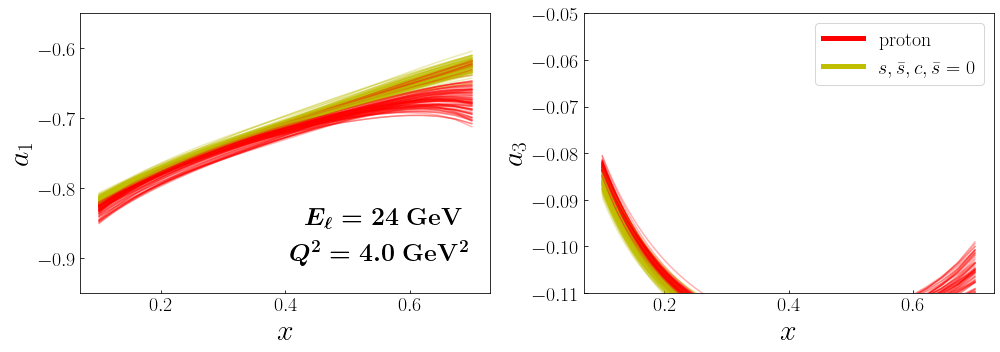

In [242]:
nrows,ncols = 1,2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

for i in range(np.shape(a3)[0]):
    ax[0].plot(x,a1[i],'r-',alpha=0.3)
    ax[1].plot(x,a3[i],'r-',alpha=0.3)

    ax[0].plot(x,a1_nosc[i],'y-',alpha=0.3)
    ax[1].plot(x,a3_nosc[i],'y-',alpha=0.3)
#     ax.plot(x,a3[i]/a1[i],'r-',alpha=0.3)

ax[1].plot([],[],'r-',lw=5,label=r'$\rm proton$')
ax[1].plot([],[],'y-',lw=5,label=r'$s,\bar{s},c,\bar{s}=0$')
ax[1].legend(fontsize=20)

ax[0].set_ylim(-0.95,-0.55)
ax[1].set_ylim(-0.11,-0.05)

ax[0].set_ylabel(r'$a_1$',size=30)
ax[1].set_ylabel(r'$a_3$',size=30)
ax[0].text(s=r'\boldmath $E_{\ell} = %.0f~{\rm GeV} \\[1ex] Q^2 = %.1f~{\rm GeV^2}$'%(E,Q2),x=0.95,
           y=0.1,ha='right',va='bottom',transform=ax[0].transAxes,size=25)
for i in range(2):
    ax[i].set_xlabel(r'$x$',size=30)
    ax[i].tick_params(which='major',axis='both',direction='in',labelsize=20)
plt.tight_layout()
plt.show()

$a_3/a_1$

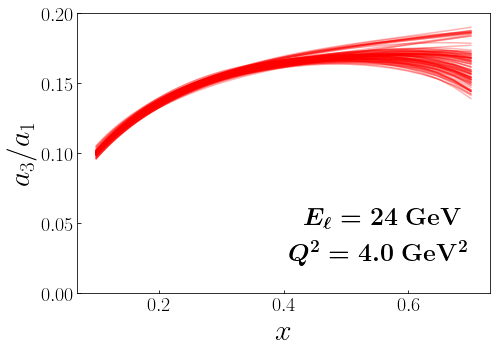

In [243]:
nrows,ncols = 1,1
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

for i in range(np.shape(a3)[0]):
    ax.plot(x,a3[i]/a1[i]          ,'r-',alpha=0.3)
#     ax.plot(x,a3_nosc[i]/a1_nosc[i],'y-',alpha=0.3)

# ax.plot([],[],'r-',lw=5,label=r'$\rm proton$')
# ax.plot([],[],'y-',lw=5,label=r'$s,\bar{s},c,\bar{s}=0$')
# ax.legend(fontsize=20)

ax.set_ylim(0.00,0.20)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$a_3/a_1$',size=30)
ax.text(s=r'\boldmath $E_{\ell} = %.0f~{\rm GeV} \\[1ex] Q^2 = %.1f~{\rm GeV^2}$'%(E,Q2),x=0.95,
           y=0.1,ha='right',va='bottom',transform=ax.transAxes,size=25)
ax.tick_params(which='major',axis='both',direction='in',labelsize=20)
    
plt.tight_layout()
plt.show()

$(a_3Y_3)/(a_1Y_1)$

In [244]:
Q2s = [1.6,2.0,4.0]

In [245]:
Y1 = [get_Y1(root_s,x,Q2_) for Q2_ in Q2s]
Y3 = [get_Y3(root_s,x,Q2_) for Q2_ in Q2s]

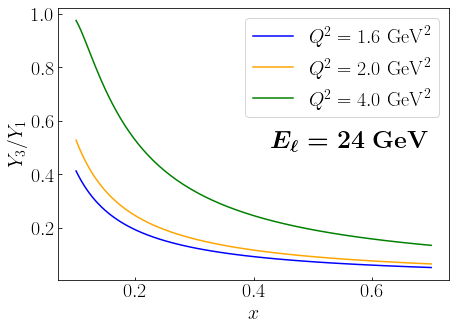

In [246]:
nrows,ncols = 1,1
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

colors = ['b','orange','g']
for i in range(3):
    ax.plot(x,Y3[i]/Y1[i],color=colors[i],label=r'$Q^2 = %.1f~{\rm GeV}^2$'%Q2s[i])

ax.set_xlabel(r'$x$',size=20)
ax.set_ylabel(r'$Y_3/Y_1$',size=20)
ax.legend(fontsize=20,loc=1)
ax.text(s=r'\boldmath $E_{\ell} = %.0f~{\rm GeV}$'%E,x=0.95,y=0.55,ha='right',va='top',transform=ax.transAxes,size=25)
ax.tick_params(which='major',axis='both',direction='in',labelsize=20)
plt.show()

$A_{\rm PV}$

In [247]:
APV      = get_APV(root_s,x,Q2)
APV_nosc = get_APV(root_s,x,Q2,omit=['s','c'])

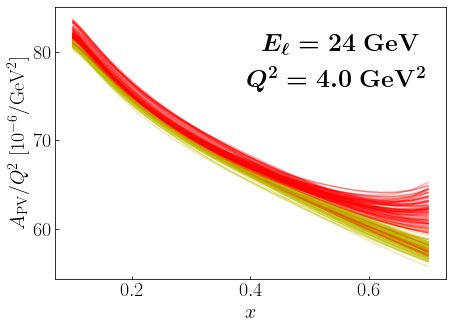

In [248]:
nrows,ncols = 1,1
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

for i in range(np.shape(a3)[0]):
    ax.plot(x,APV[i]/Q2*1e6     ,'r-',alpha=0.3)
    ax.plot(x,APV_nosc[i]/Q2*1e6,'y-',alpha=0.3)

ax.set_xlim()
ax.set_xlabel(r'$x$',size=20)
ax.set_ylabel(r'$A_{\rm PV}/Q^2~[10^{-6}/{\rm GeV}^2]$',size=20)
ax.text(s=r'\boldmath $E_{\ell} = %.0f~{\rm GeV} \\[1ex] Q^2 = %.1f~{\rm GeV^2}$'%(E,Q2),
        x=0.95,y=0.9,ha='right',va='top',transform=ax.transAxes,size=25)
ax.tick_params(which='major',axis='both',direction='in',labelsize=20)
plt.show()